# Problem 1:
classify the Size_Categorie using SVM

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

In [2]:
%matplotlib notebook

## 2. Load data

In [3]:
forest_df = pd.read_csv('forestfires.csv')

In [4]:
forest_df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


## 3. EDA

### 3.1 Data understanding

In [5]:
forest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

### 3.2 Separating data into features and target

In [6]:
# Extracting column names and sorting them to appropriate categories.
def column_segregator(df, y_name=None):
    """ Returns  three lists of column headers for feature columns, 
    numeric columns and categorical columns
    Input
    ------
    df: Dataframe
    y_name: default None. Name(str) of target column if available
    
    Output
    ------
    features, numeric_cols, cat_cols"""   
    
    cols = df.columns # List of all columns in the input dataframe.
    numeric_cols = [col for col in cols if (df[col].dtypes != 'object') and col != y_name]
    cat_cols = [col for col in cols if (df[col].dtypes == 'object') and col != y_name]
    features = [col for col in cols if col != y_name]
    
    return features, numeric_cols, cat_cols 

In [7]:
def Xy_split(df, y_name=None, y_col=True):
    """Splits the input dataframe into features and target
    input
    -----
    df: Input dataframe
    y_name: default None. Name(str) of target column if available
    y_col: 'True' if y column is present in input dataframe, else 'False'.
    
    output
    ------
    X (features) , y (target) if y colum is present else only X"""
    
    target = y_name
    feature_col,_,_ = column_segregator(df, target)
    if y_col == True:
        # separating features and target.
        X = df.loc[:, feature_col]
        y = df.loc[:, target]
        return X,y
    else:
        X = df.loc[:, feature_col]
        return X

In [8]:
# Column segregation.
features, numeric_cols, cat_cols = column_segregator(forest_df, y_name='size_category')

In [9]:
X, y = Xy_split(forest_df, y_name='size_category', y_col=True)

### 3.3 Visualizations
#### 3.1 Feature distribution - numeric features

<IPython.core.display.Javascript object>


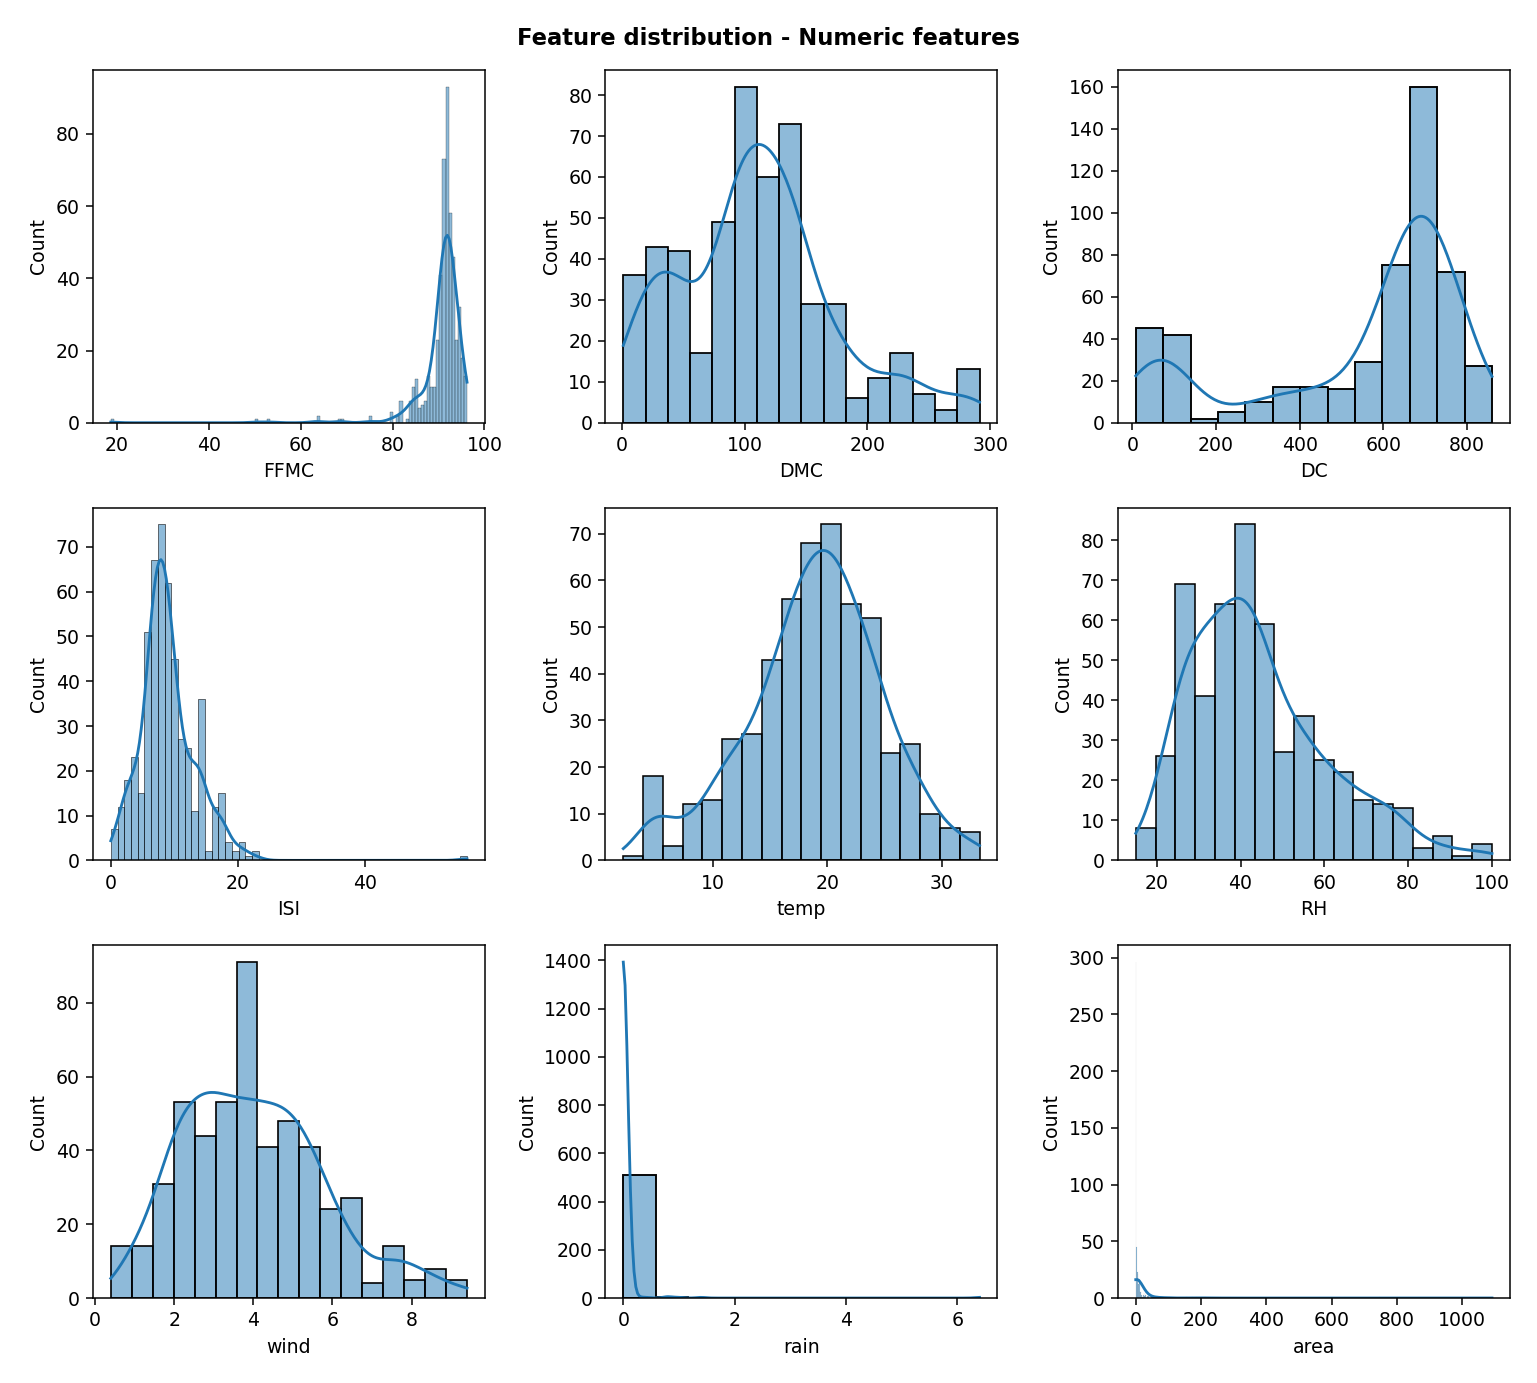

In [10]:
fig, axes = plt.subplots(3,3, figsize=(10,9))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.histplot(data=X, x=X[numeric_cols[idx]], ax=ax, kde=True)
    
fig.suptitle('Feature distribution - Numeric features', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

#### 3.3.2 Feature distribution - categorical features

<IPython.core.display.Javascript object>


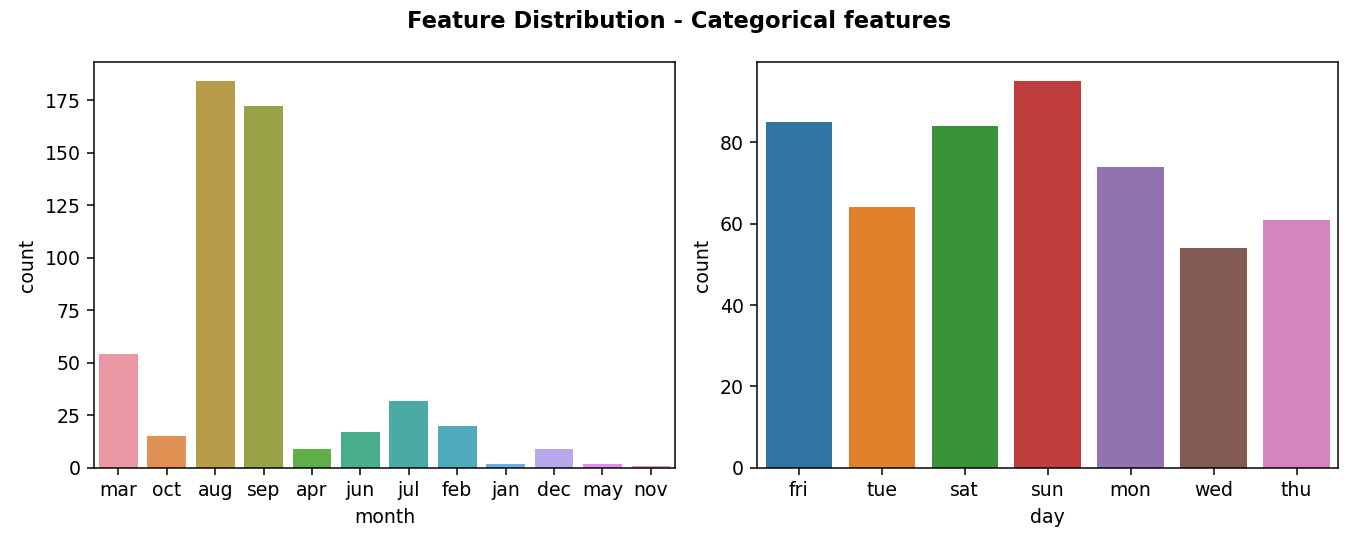

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.countplot(data=X, x=X[cat_cols[idx]], ax=ax)
    
fig.suptitle('Feature Distribution - Categorical features', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

#### Target distribution

<IPython.core.display.Javascript object>


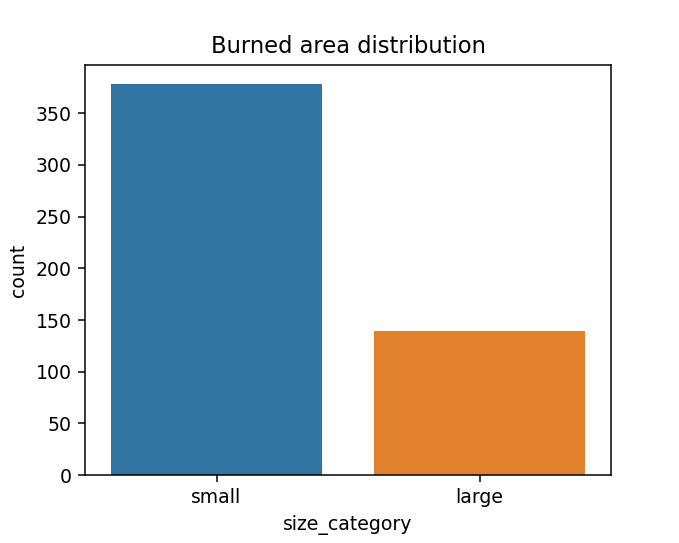

In [12]:
fig, ax = plt.subplots(figsize=(5,4))
sns.countplot(x=y, ax=ax)
ax.set_xlabel('size_category')
ax.set_title('Burned area distribution')
plt.show()

In [13]:
X_1 = X[numeric_cols]
y_1 = y.apply(lambda x: 0 if(x=='small') else 1)

### 3.3.5 Heatmap - to find correlations

<IPython.core.display.Javascript object>


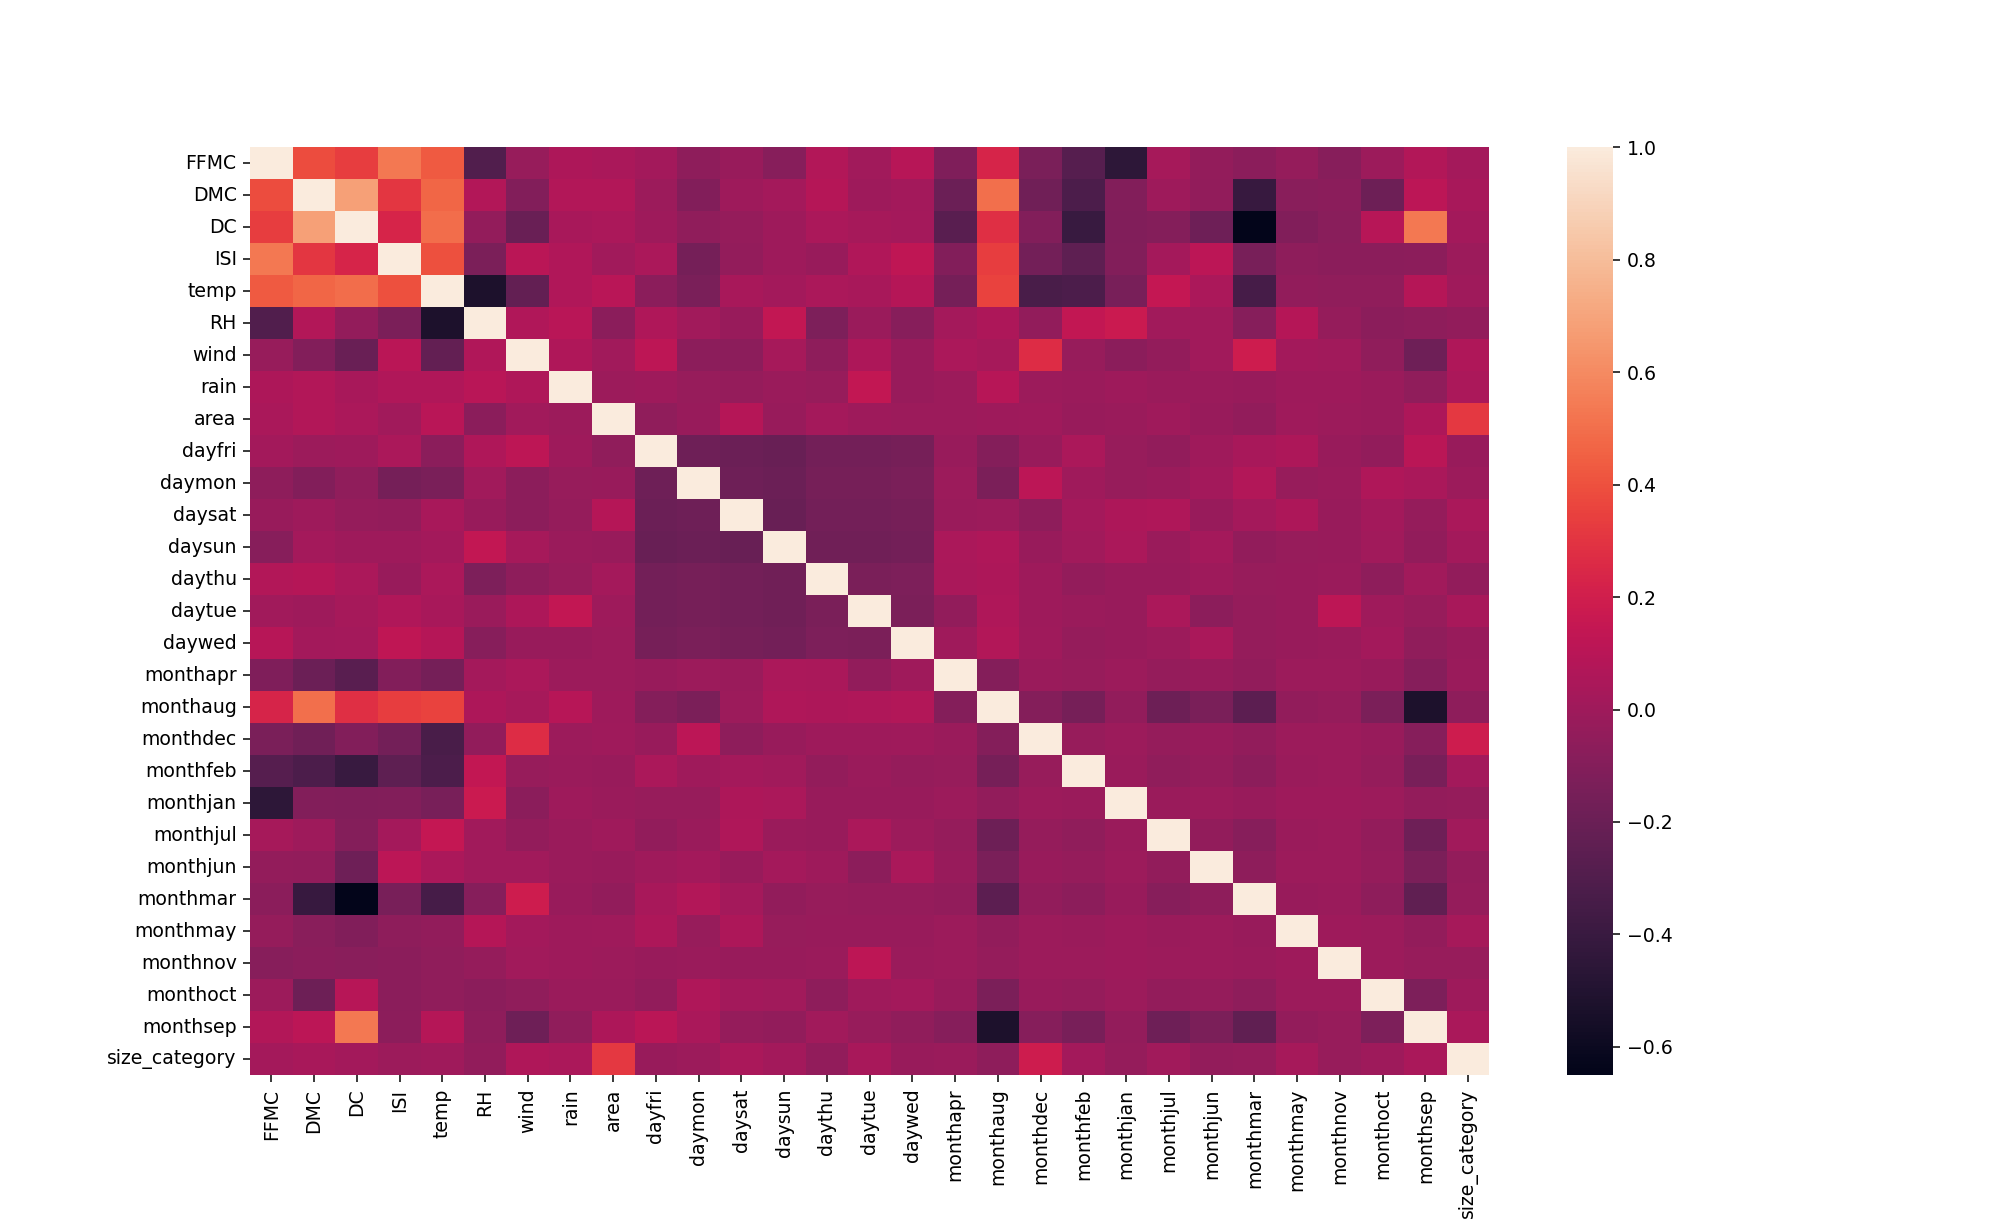

In [14]:
df_heatmap = pd.concat([X_1, y_1], axis=1)
fig, ax = plt.subplots(figsize=(13,8))
sns.heatmap(df_heatmap.corr(), ax=ax, annot=False)
plt.show()

### 3.3.6 plot output labels as clusters

In [15]:
def cluster_visualization(df_sc, labels):
    # PCA - N-D to 2D for scatterplot.
    pca = PCA(2)
    df_pca = pca.fit_transform(df_sc)
    u_labels = np.unique(labels)
    
    # Plotting
    fig, ax = plt.subplots()
    for i in u_labels:
        ax.scatter(df_pca[labels == i, 0], df_pca[labels == i, 1], label=i)
        
    ax.legend()    

In [16]:
scaler = MinMaxScaler()
X_1sc = scaler.fit_transform(X_1)

<IPython.core.display.Javascript object>


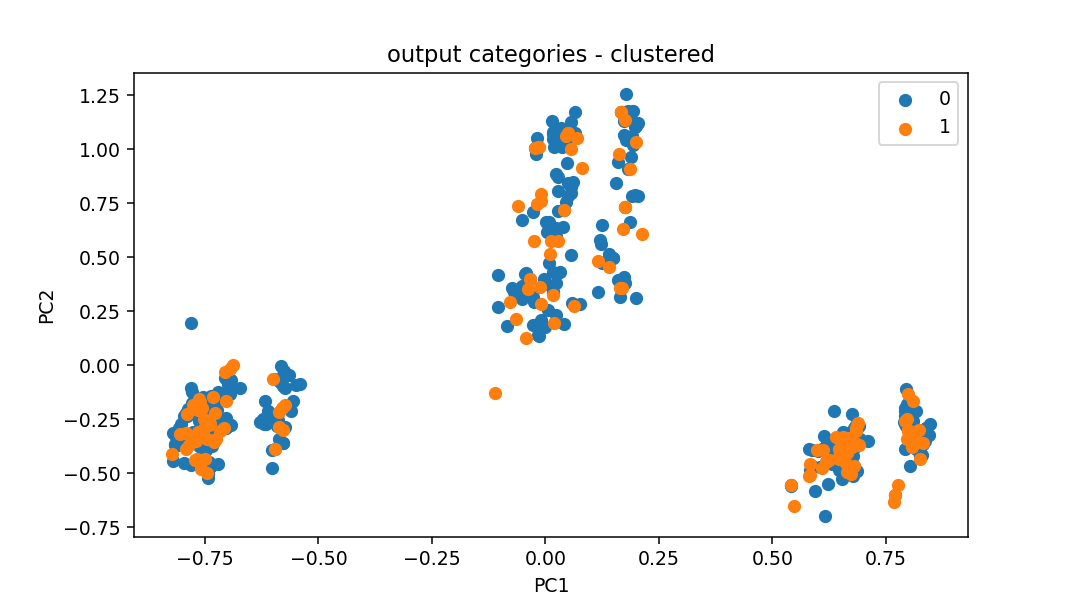

In [17]:
cluster_visualization(X_1sc, y_1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('output categories - clustered')
plt.show()

### 3.4 Observations

- 517 records, 30 feature columns and one target column.
- 11 features in total. We remove 'month' and 'day' columns since they are one hot encoded already in the dataset.
- No null values, all features have correct datatypes.
- Not all numeric features are normally distributed.
- Only the 'day' feature has a uniform distribution, 'month' feature is non uniform.
- Output distribution is not balanced.
- From the heatmap, we can see some strong negative correlations and some strong positive correlations.
- From the clusters, we see that it is hard to differentiate between the 0 and 1 class ('small and 'large') i.e it is hard to draw a a clear boundary between the two clusters.

## 4. Model building

### 4.1 Baseline model with cross validation:

In [18]:
# Data preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ('num_trf', numeric_transformer, numeric_cols[:9])
], remainder='passthrough')

In [20]:
sv_clf = SVC()

In [21]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf)
])

In [22]:
def cross_validator(clf, Xdf, ydf, cv=5):
    # K fold cross validation:
    crv_scores_auc = cross_val_score(estimator=clf, X=Xdf, y=ydf, cv=cv, scoring='roc_auc')
    crv_scores_prec = cross_val_score(estimator=clf, X=Xdf, y=ydf, cv=cv, scoring='precision')
    crv_scores_rec = cross_val_score(estimator=clf, X=Xdf, y=ydf, cv=cv, scoring='recall')
    
    vals = [round(crv_scores_auc.mean(),4),
            round(crv_scores_prec.mean(),4),
            round(crv_scores_rec.mean(),4)
           ]
    return vals

In [23]:
def model_summary(vals):
    # Summarizing scores:
    print("mean AUC score           :{} ".format(vals[0]))
    print("mean precision(1 class)  :{} ".format(vals[1]))
    print("mean recall(1 class)     :{} ".format(vals[2]))

In [24]:
baseline_scores = cross_validator(clf=clf,
                                  Xdf=X_1,
                                  ydf=y_1,
                                  cv=5)

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

In [25]:
scores = {}

In [26]:
scores['baseline'] = baseline_scores

In [27]:
model_summary(scores['baseline'])

mean AUC score           :0.6278 
mean precision(1 class)  :0.2 
mean recall(1 class)     :0.0074 


In [28]:
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_1,
                                                    y_1,
                                                    test_size=0.2,
                                                    stratify=y_1,
                                                    random_state=42)

In [29]:
clf.fit(X_train_bl, y_train_bl)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trf',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['FFMC', 'DMC', 'DC', 'ISI',
                                                   'temp', 'RH', 'wind', 'rain',
                                                   'area'])])),
                ('classifier', SVC())])

### 4.2 Baseline model evaluation

In [30]:
y_pred_bl = clf.predict(X_test_bl)

In [31]:
def display_results(y_test, y_pred, clf):
    """Displays model evaluation/performance report that includes
    accuracy_score, confusion_matrix, precision_score, and 
    recall_score.
    input
    -----
    y_test, y_pred
    
    output
    ------
    Model evaluation/performance report"""
    print(classification_report(y_test, y_pred))
    #print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=clf.classes_, ax=ax)

              precision    recall  f1-score   support

           0       0.75      1.00      0.85        76
           1       1.00      0.07      0.13        28

    accuracy                           0.75       104
   macro avg       0.87      0.54      0.49       104
weighted avg       0.81      0.75      0.66       104



<IPython.core.display.Javascript object>


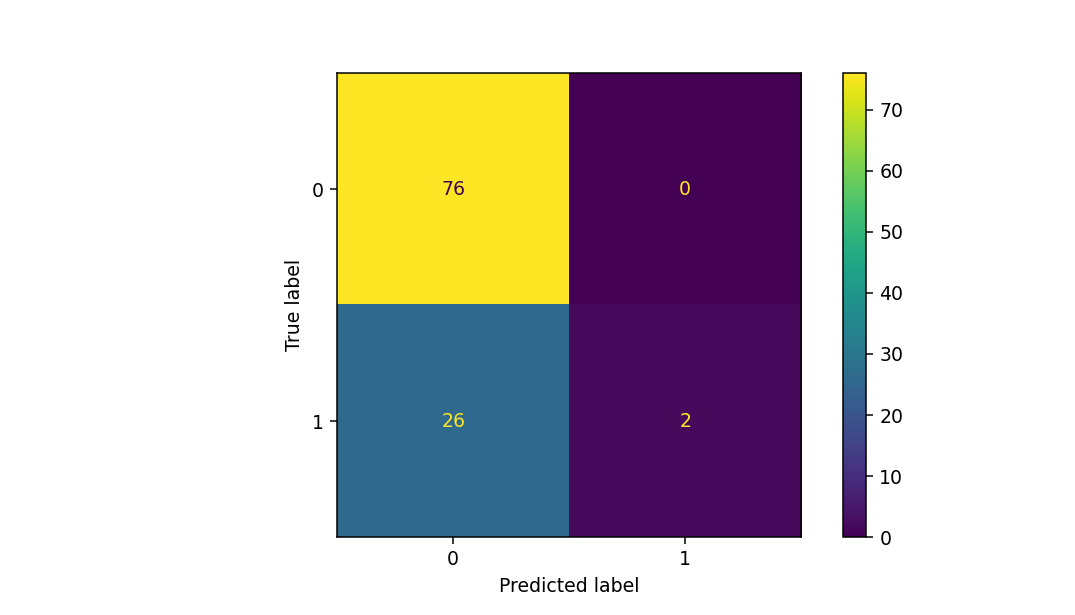

In [32]:
display_results(y_test_bl, y_pred_bl, clf=clf)

#### Observations:
- Baseline model is performing very poorly. Almost All 1 class falsely classified as 0.

## 5. Experimenting with different models:

### 5.1 Model 1:
updates: trying with a linear kernel.

In [33]:
sv_clf_m1 = SVC(kernel='linear')

In [34]:
clf_m1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_m1)
])

In [35]:
scores['model_1'] = cross_validator(clf=clf_m1,
                                    Xdf=X_1,
                                    ydf=y_1,
                                    cv=5)

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
model_summary(scores['model_1'])

mean AUC score           :0.9822 
mean precision(1 class)  :0.3 
mean recall(1 class)     :0.0146 


**Note:** No improvement in accuracy score, minor improvement in precision and recall score

### 5.2 Model 2:
updates: trying with a polynomial kernel.

In [37]:
sv_clf_m2 = SVC(kernel='poly')

In [38]:
clf_m2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_m2)
])

In [39]:
scores['model_2'] = cross_validator(clf=clf_m2,
                                    Xdf=X_1,
                                    ydf=y_1,
                                    cv=5)

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
model_summary(scores['model_2'])

mean AUC score           :0.6167 
mean precision(1 class)  :0.3 
mean recall(1 class)     :0.0217 


**Note:** No significant improvement in accuracy score, minor improvement recall score

### 5.3 Model 3:
updates: trying with a polynomial kernel, and experimenting with gamma

In [41]:
sv_clf_m3 = SVC(kernel='poly', gamma=0.1, C=0.1)

clf_m3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_m3)
])

scores['model_3'] = cross_validator(clf=clf_m3,
                                    Xdf=X_1,
                                    ydf=y_1,
                                    cv=5)

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

In [42]:
model_summary(scores['model_3'])

mean AUC score           :0.617 
mean precision(1 class)  :0.0 
mean recall(1 class)     :0.0 


### 5.4 Model 4

In [43]:
sv_clf_m4 = SVC(kernel='poly', gamma=0.1, C=0.3)

clf_m4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_m4)
])

scores['model_4'] = cross_validator(clf=clf_m4,
                                    Xdf=X_1,
                                    ydf=y_1,
                                    cv=5)

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

In [44]:
model_summary(scores['model_4'])

mean AUC score           :0.6194 
mean precision(1 class)  :0.0 
mean recall(1 class)     :0.0 


### 5.5 Model 5:
Updates: Since a value < 1 for both C and gamma result in low precesion and recall score above, we try with higer values for the same parameters.

In [45]:
sv_clf_m5 = SVC(kernel='poly', gamma=10, C=50, random_state=42)

clf_m5 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_m5)
])

scores['model_5'] = cross_validator(clf=clf_m5,
                                    Xdf=X_1,
                                    ydf=y_1,
                                    cv=5)

In [46]:
model_summary(scores['model_5'])

mean AUC score           :0.8554 
mean precision(1 class)  :0.6804 
mean recall(1 class)     :0.6685 


In [47]:
clf_m5.fit(X_train_bl, y_train_bl)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trf',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['FFMC', 'DMC', 'DC', 'ISI',
                                                   'temp', 'RH', 'wind', 'rain',
                                                   'area'])])),
                ('classifier',
                 SVC(C=50, gamma=10, kernel='poly', random_state=42))])

In [48]:
y_pred_m5 = clf_m5.predict(X_test_bl)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        76
           1       0.77      0.61      0.68        28

    accuracy                           0.85       104
   macro avg       0.82      0.77      0.79       104
weighted avg       0.84      0.85      0.84       104



<IPython.core.display.Javascript object>


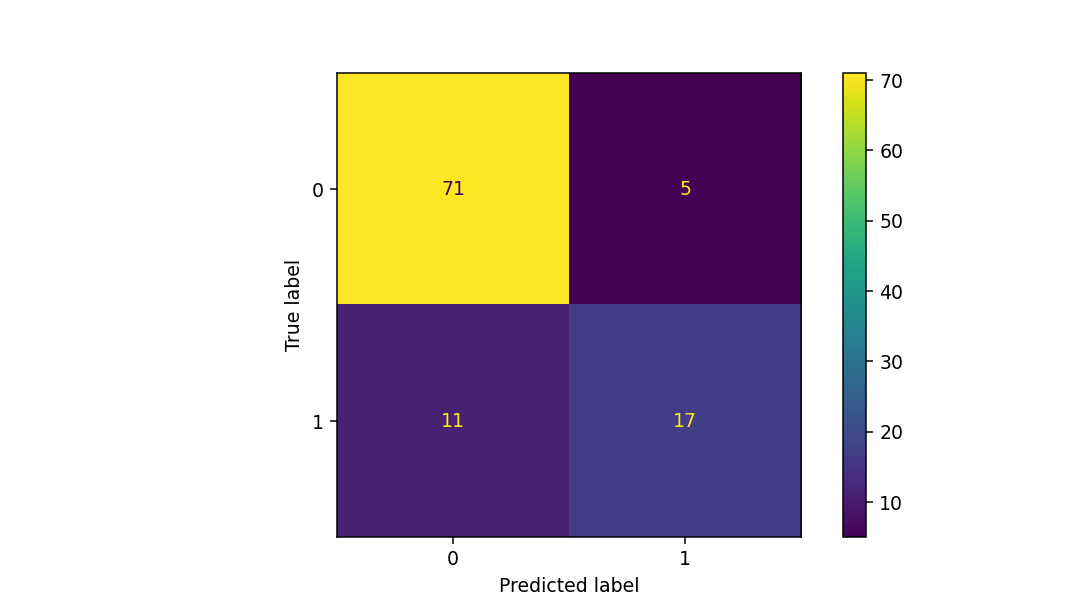

In [49]:
display_results(y_test_bl, y_pred_m5, clf=clf_m5)

- From the above trial and error method , we can see that, a 'poly' kernel wrth C and gamma > 1 results in improvement of scores.
- Although the precision and recall scores are somwhat better(close by compared to previous models), the number of misclassifications for 0 class is still large. 

### 5.6 Gridsearch CV to find best params

In [50]:
sv_clf_gs = SVC()

clf_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_gs)
])

In [51]:
clf_gs.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num_trf', 'preprocessor__num_trf__memory', 'preprocessor__num_trf__steps', 'preprocessor__num_trf__verbose', 'preprocessor__num_trf__scaler', 'preprocessor__num_trf__scaler__clip', 'preprocessor__num_trf__scaler__copy', 'preprocessor__num_trf__scaler__feature_range', 'classifier__C', 'classifier__break_ties', 'classifier__cache_size', 'classifier__class_weight', 'classifier__coef0', 'classifier__decision_function_shape', 'classifier__degree', 'classifier__gamma', 'classifier__kernel', 'classifier__max_iter', 'classifier__probability', 'classifier__random_state', 'classifier__shrinking', 'classifier__tol', 'classifier__verbose'])

In [52]:
parameters = {'classifier__kernel':['linear', 'rbf', 'poly', 'sigmoid'],
             'classifier__gamma': [0.1, 0.5, 1, 5, 10, 15, 25, 30, 50],
             'classifier__C': [0.01, 0.1, 1, 5, 10, 15, 25, 30, 50]
             }

In [53]:
# parameters = {'classifier__kernel':['poly'],
#              'classifier__gamma': [50],
#              'classifier__C': [1, 50]
#              }

In [54]:
grid_search = GridSearchCV(estimator=clf_gs,
    param_grid=parameters,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5)

In [55]:
grid_search.fit(X_1, y_1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trf',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['FFMC',
                                                                          'DMC',
                                                                          'DC',
                                                                          'ISI',
                                                                          'temp',
                                                                          'RH',
                                                               

In [56]:
grid_search.best_params_ 

{'classifier__C': 50, 'classifier__gamma': 0.1, 'classifier__kernel': 'linear'}

In [57]:
grid_search.best_score_ 

0.9862857142857143

### 5.7 Model 6 

In [58]:
sv_clf_g1 = SVC(C=50,
    kernel='linear',
    gamma=0.1,)

clf_g1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_g1)
])

In [59]:
clf_g1.fit(X_train_bl, y_train_bl)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trf',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['FFMC', 'DMC', 'DC', 'ISI',
                                                   'temp', 'RH', 'wind', 'rain',
                                                   'area'])])),
                ('classifier', SVC(C=50, gamma=0.1, kernel='linear'))])

#### 5.7.1 Model evaluation - Model 6

In [60]:
y_pred_gs = clf_g1.predict(X_test_bl)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        76
           1       1.00      0.46      0.63        28

    accuracy                           0.86       104
   macro avg       0.92      0.73      0.77       104
weighted avg       0.88      0.86      0.84       104



<IPython.core.display.Javascript object>


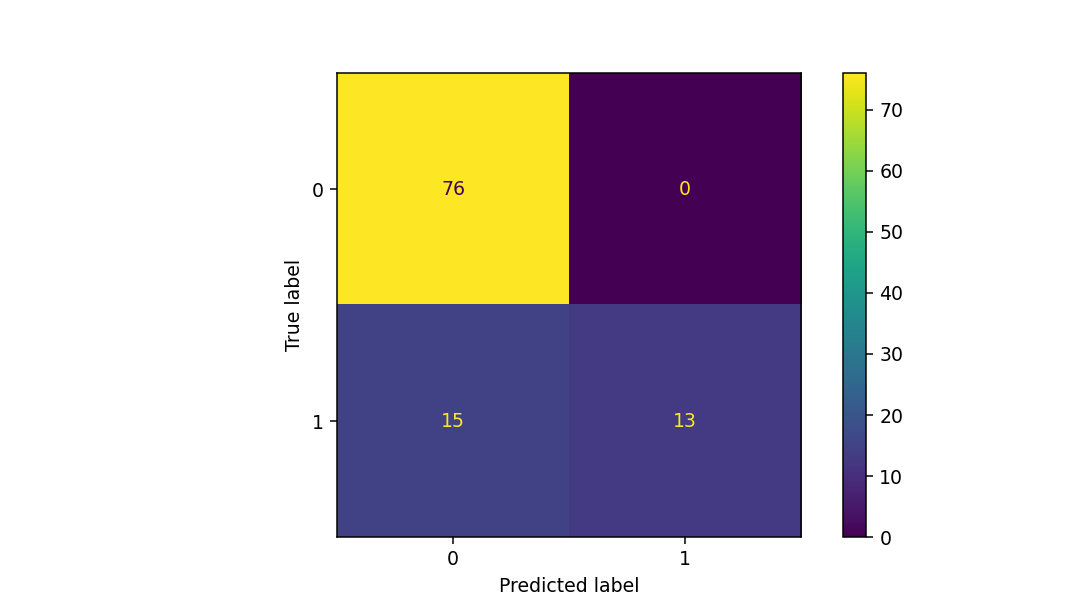

In [61]:
display_results(y_test_bl, y_pred_gs, clf=clf_g1)

#### Observations:
- The parameters suggested by gridsearch still results in lot of misclassifications. 
- We may need to change the encoding or use some other preprocessing technique.

### 6. Change data preprocessing approach:
Updates: label encode date and month columns, and gridsearch.

In [62]:
forest_df1 = forest_df.copy()# Copy to new dataframe.

In [63]:
forest_df1.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


#### 6.1 Ordinal encoding of date and month columns and encoding targer labels.

In [64]:

months_dict = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
days_dict = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}
burnt_ar_dict = {'small':0, 'large':1}

In [65]:
forest_df1['month'] = forest_df1['month'].apply(lambda x: months_dict[x])

In [66]:
forest_df1['day'] = forest_df1['day'].apply(lambda x: days_dict[x])

In [67]:
forest_df1['size_category'] = forest_df1['size_category'].apply(lambda x: burnt_ar_dict[x])

In [68]:
req_features = list(forest_df1.columns[:11]) # Drop all the one hot encoded features.

In [69]:
req_features

['month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'area']

In [70]:
X_2 = forest_df1[req_features]

In [71]:
y_2 = forest_df1['size_category']

In [72]:
y_2

0      0
1      0
2      0
3      0
4      0
      ..
512    1
513    1
514    1
515    0
516    0
Name: size_category, Length: 517, dtype: int64

#### 6.2 Heatmap to see correlations.

<IPython.core.display.Javascript object>


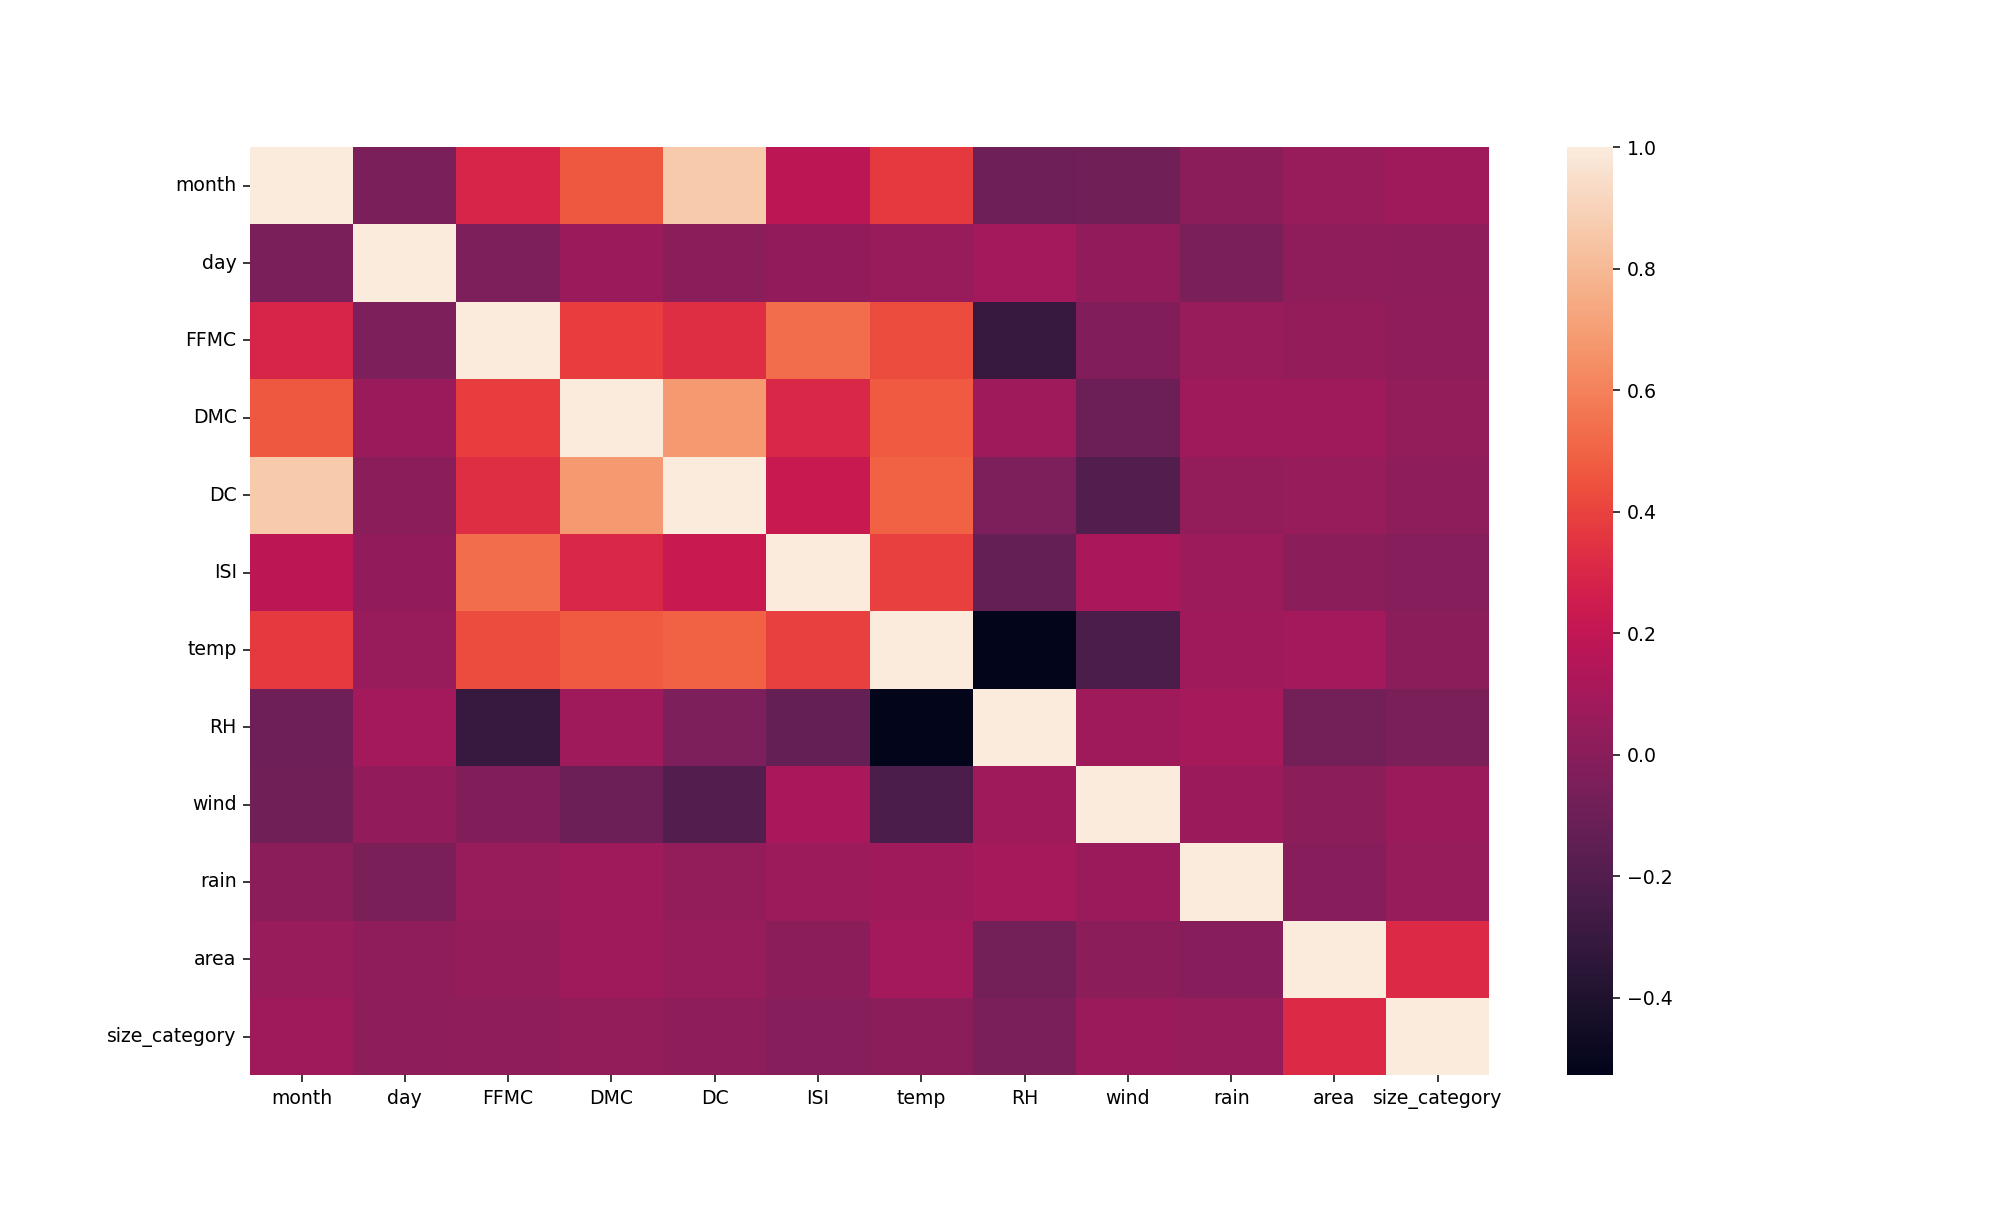

In [73]:
df_heatmap = pd.concat([X_2, y_2], axis=1)
fig, ax = plt.subplots(figsize=(13,8))
sns.heatmap(df_heatmap.corr(), ax=ax, annot=False)
plt.show()

#### 6.3 Gridsearch for best parameters

In [74]:
sv_clf_gs2 = SVC()

# Data preprocessing
numeric_transformer2 = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor2 = ColumnTransformer(transformers=[
    ('num_trf', numeric_transformer2, req_features)
])

clf_gs2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('classifier', sv_clf_gs2)
])


In [75]:
# Gridsearch to find the best parameters.
grid_search2 = GridSearchCV(estimator=clf_gs2,
    param_grid=parameters,
    scoring='recall',
    n_jobs=-1,
    cv=5)

In [76]:
%%time
grid_search2.fit(X_2, y_2)

Wall time: 8.64 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_trf',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['month',
                                                                          'day',
                                                                          'FFMC',
                                                                          'DMC',
                                                                          'DC',
                                                                          'ISI',
                                                                          'temp',
                                                            

In [77]:
grid_search2.best_params_ 

{'classifier__C': 50, 'classifier__gamma': 0.1, 'classifier__kernel': 'linear'}

In [78]:
grid_search2.best_score_ 

0.9785714285714286

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, stratify=y_2, random_state=42)

#### 6.4 Update the SVC with parameters obtained from gridsearch - Model 7

In [80]:
sv_gs_fin = SVC(C=50,
    kernel='linear',
    gamma=0.1)

In [81]:
clf_gs_fin = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('classifier', sv_gs_fin)
])

In [82]:
clf_gs_fin.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trf',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['month', 'day', 'FFMC',
                                                   'DMC', 'DC', 'ISI', 'temp',
                                                   'RH', 'wind', 'rain',
                                                   'area'])])),
                ('classifier', SVC(C=50, gamma=0.1, kernel='linear'))])

#### 6.5 Model evaluation - Model 7

In [83]:
y_pred_gs2 = clf_gs_fin.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        76
           1       1.00      0.96      0.98        28

    accuracy                           0.99       104
   macro avg       0.99      0.98      0.99       104
weighted avg       0.99      0.99      0.99       104



<IPython.core.display.Javascript object>


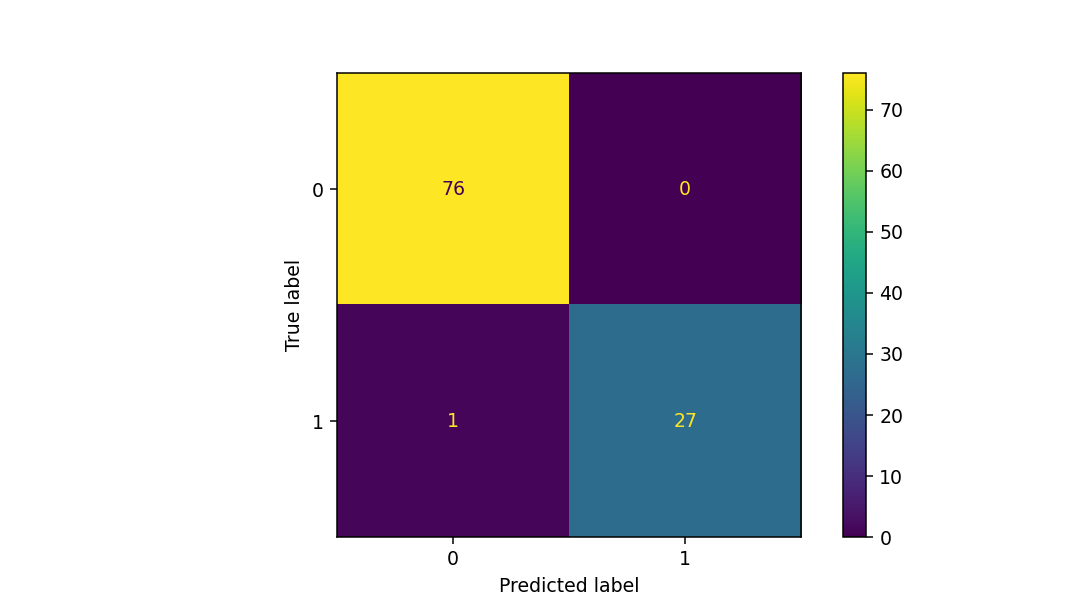

In [84]:
display_results(y_test, y_pred_gs2, clf=clf_gs_fin)

## 7. Observations
- From the above mdels we see that Model 7 performs the best with very high precision and recall scores.

## 8. Conclusions:
- A Support vector classifier was used to classify the burnt area from forest fire data and its performance was evaluated using Kfold validation. The hyperparameters for the model were found using gridsearch cv.
- From the above analysis, it was found that Model7 was best for classifying the forest fire data.